## This notebook explores q-learned policies:

In [2]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.utils import misc
from learning.policies.discrete_optimal_policy import DiscretePolicyConstructor
from dcc import Parameters, AAV, OAV


import os
import numpy as np
import pickle
import copy
import keras
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

import tensorflow_lattice as tfl

from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



In [3]:
name = 'DDQN_20K'
log_path = os.path.join(misc.RESOURCE_ROOT, 'models', name)
logs = os.listdir(log_path)
logs

['20200807-105002', '20200810-151326']

In [4]:
def construct_paths(log_num):
    models = os.listdir(os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num]))
    model_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num])
    env_path =  os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'env.pkl')
    try:
        buffer_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'buffer.pkl')
    except:
        print('No buffer found.')

    with open(buffer_path,'rb') as f:
        buffer = pickle.load(f)
    return model_path, buffer

model_path, buffer = construct_paths(0)
os.listdir(model_path)

['buffer.pkl', 'env.pkl', 'main_net.h5', 'train_config.pkl']

In [5]:
agent = DQNAgent.load(model_path)
agent.main_net.compile(loss='MSE')

[WARNING] [2020-08-11 10:44:50,779] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-08-11 10:44:50,869] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [6]:
def create_map(agent, lam_lim=7):
    w_points = 80
    l_points = 80
    l = np.linspace(agent.env.observation_space.low[0], lam_lim, l_points)
    w = np.linspace(agent.env.observation_space.low[1], agent.env.observation_space.high[1], w_points)
    w_normalized = np.linspace(0, 1, w_points)
    l_normalized = np.linspace(0, agent.env.observation((lam_lim,100))[0], l_points)
    wwn, lln = np.meshgrid(w_normalized, l_normalized)
    ww, ll = np.meshgrid(w, l)
    z = np.zeros_like(ww)
    p = np.zeros_like(ww)
    for i, xp in enumerate(w_normalized):
        for j, yp in enumerate(l_normalized):
            fixed_obs = np.array([yp, xp])
            z[j, i] = np.amax(agent.main_net.predict_on_batch(fixed_obs[None, :]))
            p[j, i] = agent.env.action(np.argmax(agent.main_net.predict_on_batch(fixed_obs[None,:])))
    return ww, ll, p, z
ww, ll, aa, z = create_map(agent)

Text(0.5, 1.0, 'Simplest default with labels')

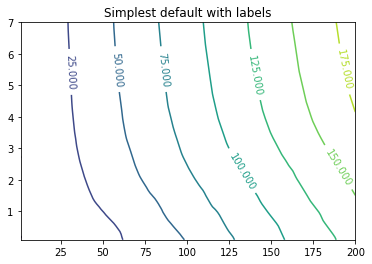

In [7]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

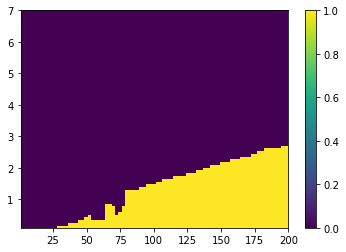

In [8]:
plt.pcolor(ww, ll, aa)
plt.colorbar()
plt.show()

Optimal policy for discrete actions

In [37]:
# environment = CollectionsEnv(agent.env.w0, agent.env.params, max_lambda=7.0)
# environment = DiscretizedActionWrapper(environment, agent.env.action_bins)
# discrete_policy_opt = DiscretePolicyConstructor(environment, 5000, pts=(200,200))
# discrete_policy_opt.run(verbose=True)

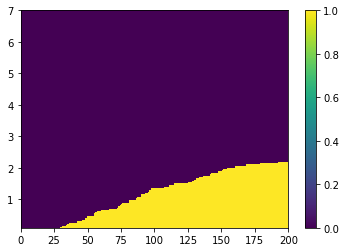

In [40]:
plt.pcolor(discrete_policy_opt.ww, discrete_policy_opt.ll, discrete_policy_opt.policy)
plt.colorbar()
plt.show()

In [22]:
def evaluate_agent(agent, s0=np.array([0.11, 200]), n=500, aav=False):
    # Construct the environment
    environment = CollectionsEnv(w0=agent.env.w0, params=agent.env.params, reward_shaping='discrete', randomize_start=False, starting_state=s0)
    environment = StateNormalization(environment=environment)
    rewards = []
    w_states = []
    l_states = []
    actions = []
    for i in range(n):
        episode_reward = 0
        done = False
        state = environment.reset()
        while not done:
            # action = np.argmax(agent.main_net.predict_on_batch(state[None,:]))
            if aav:
                action = 0.0
            else:
                action, q = agent.get_action(state, epsilon=0.0)
            # action = 0
            actions.append(action)
            state, reward, done, _ = environment.step(action)
            episode_reward += reward
            converted_state = environment.convert_back(state)
            # w_states.append(converted_state[1])
            # l_states.append(converted_state[0])
            if episode_reward>200:
                break
            if done:
                rewards.append(episode_reward)
    return rewards

Construct value function in (lambda, w) space

In [23]:
from tqdm import tqdm

def true_value(agent, lam_lim):
    w_points = 40
    l_points = 40
    l = np.linspace(agent.env.observation_space.low[0], lam_lim, l_points)
    w = np.linspace(agent.env.observation_space.low[1], agent.env.observation_space.high[1], w_points)
    w_normalized = np.linspace(0, 1, w_points)
    l_normalized = np.linspace(0, agent.env.observation((lam_lim,100))[0], l_points)
    wwn, lln = np.meshgrid(w_normalized, l_normalized)
    ww, ll = np.meshgrid(w, l)
    z = np.zeros_like(ww)
    p = np.zeros_like(ww)
    for i, xp in enumerate(tqdm(w_normalized)):
        for j, yp in enumerate(l_normalized):
            fixed_obs = np.array([yp, xp])
            z[j, i] = np.mean(evaluate_agent(agent, s0=np.array([l[j], w[i]]), n=1000))
    return ww, ll, z

www, lll, zz = true_value(agent, lam_lim=7)

  0%|                                                                                           | 0/40 [00:00<?, ?it/s]c:\users\majke\anaconda3\envs\tf2-gpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|█████████████████████████████████████████████████████████████████████████████| 40/40 [19:45:21<00:00, 1778.04s/it]


In [26]:
# np.save('www.npy', www)

In [27]:
# np.save('lll.npy', lll)

In [28]:
# np.save('z.npy', zz)

In [51]:
# zz = np.load('z.npy')

In [52]:
# www = np.load('www.npy')

In [53]:
# lll = np.load('lll.npy')

[INFO] [2020-08-12 08:53:39,773] [AAV] - Instantiated @ AAV
[INFO] [2020-08-12 08:53:39,791] [OAV] - Launching the value function procedure.
[INFO] [2020-08-12 08:53:39,792] [OAV] - Computing the value function on (0.00, 21.10].
[INFO] [2020-08-12 08:53:39,799] [OAV] - Computing the value function on (21.10, 23.45].
[INFO] [2020-08-12 08:53:40,732] [OAV] - Computing the value function on (23.45, 26.05].
[INFO] [2020-08-12 08:53:41,323] [OAV] - Computing the value function on (26.05, 28.95].
[INFO] [2020-08-12 08:53:41,909] [OAV] - Computing the value function on (28.95, 32.16].
[INFO] [2020-08-12 08:53:42,172] [OAV] - Computing the value function on (32.16, 35.73].
[INFO] [2020-08-12 08:53:42,693] [OAV] - Computing the value function on (35.73, 39.71].
[INFO] [2020-08-12 08:53:43,178] [OAV] - Computing the value function on (39.71, 44.12].
[INFO] [2020-08-12 08:53:43,633] [OAV] - Computing the value function on (44.12, 49.02].
[INFO] [2020-08-12 08:53:44,380] [OAV] - Computing the valu

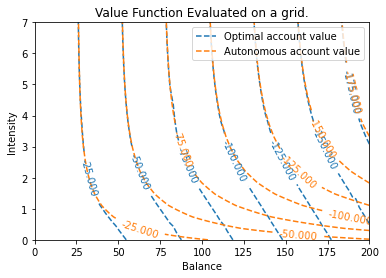

In [29]:
oav = OAV(agent.env.params, agent.env.w0, lmax=7)
oav.solve_v()
fig, ax = oav.plot_vf(plot_aav_flag=True)

In [30]:
CS = ax.contour(www, lll, -zz)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Value function')

Text(0.5, 1.0, 'Value function')

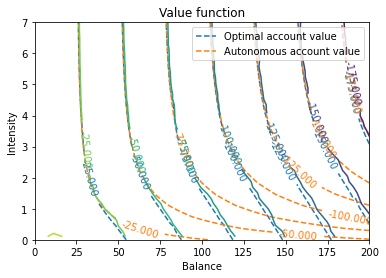

In [31]:
fig

Comparison on montecarlo value with 200 evaluations per point

In [41]:
def get_frontier(ww, ll, aa):
    w_vector = ww[1, :]
    l_vector = ll[:, 1]
    lstars = np.zeros_like(w_vector)
    for i, w in enumerate(w_vector):
        try:
            l_star_index = np.max(np.nonzero(aa[:, i]))
            l_star = l_vector[l_star_index]
            lstars[i] = l_star
        except:
            lstars[i] = 0.0
    return w_vector, lstars

w_front, l_front = get_frontier(ww, ll, aa)
w_front_opt, l_front_opt = get_frontier(discrete_policy_opt.ww, discrete_policy_opt.ll, discrete_policy_opt.policy)

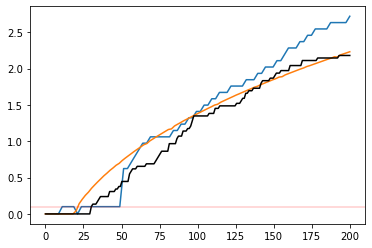

In [42]:
plt.plot(w_front, l_front)
plt.plot(oav.w_vector, oav.lambdastars)
plt.plot(w_front_opt, l_front_opt, color='black')
plt.axhline(0.1, linewidth=0.3, color='red')

## $\kappa=0.7$, $c=10$, $rho=0.14$
Reference parameters from MS paper -- 3 fully trained policies

In [19]:
ws = []
ls = []
for i, log in enumerate(logs):
    model_path, buffer = construct_paths(i)
    agent = DQNAgent.load(model_path)
    agent.main_net.compile(loss='MSE')
    ww, ll, aa, z = create_map(agent)
    w_front, l_front = get_frontier(ww, ll, aa)
    ws.append(w_front)
    ls.append(l_front)

[WARNING] [2020-08-11 11:50:04,745] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-08-11 11:50:04,838] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-08-11 11:50:18,771] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-08-11 11:50:18,863] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.


[INFO] [2020-08-11 11:50:28,840] [AAV] - Instantiated @ AAV
[INFO] [2020-08-11 11:50:28,855] [OAV] - Launching the value function procedure.
[INFO] [2020-08-11 11:50:28,856] [OAV] - Computing the value function on (0.00, 21.10].
[INFO] [2020-08-11 11:50:28,863] [OAV] - Computing the value function on (21.10, 23.45].
[INFO] [2020-08-11 11:50:29,796] [OAV] - Computing the value function on (23.45, 26.05].
[INFO] [2020-08-11 11:50:30,389] [OAV] - Computing the value function on (26.05, 28.95].
[INFO] [2020-08-11 11:50:30,979] [OAV] - Computing the value function on (28.95, 32.16].
[INFO] [2020-08-11 11:50:31,231] [OAV] - Computing the value function on (32.16, 35.73].
[INFO] [2020-08-11 11:50:31,763] [OAV] - Computing the value function on (35.73, 39.71].
[INFO] [2020-08-11 11:50:32,242] [OAV] - Computing the value function on (39.71, 44.12].
[INFO] [2020-08-11 11:50:32,701] [OAV] - Computing the value function on (44.12, 49.02].
[INFO] [2020-08-11 11:50:33,434] [OAV] - Computing the valu

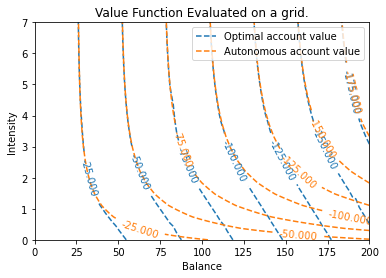

In [20]:
oav = OAV(agent.env.params, agent.env.w0, lmax=7)
oav.solve_v()
fig, ax = oav.plot_vf(plot_aav_flag=True)

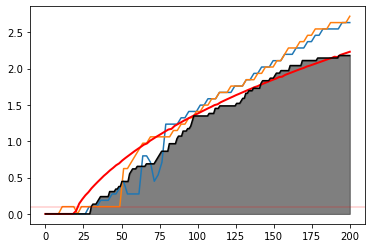

In [43]:
plt.plot(np.array(ws).T, np.array(ls).T)
plt.plot(oav.w_vector, oav.lambdastars, color='red', linewidth=2)
plt.plot(w_front_opt, l_front_opt, color='black')
plt.fill_between(w_front_opt, 0, l_front_opt, color = 'black', alpha = 0.5)
plt.axhline(0.1, linewidth=0.3, color='red')

### check the value

In [32]:
rew_ag = evaluate_agent(agent, n=1000)
rew_aav = evaluate_agent(agent, n=1000, aav=True)

[INFO] [2020-08-12 08:57:00,948] [AAV] - Instantiated @ AAV


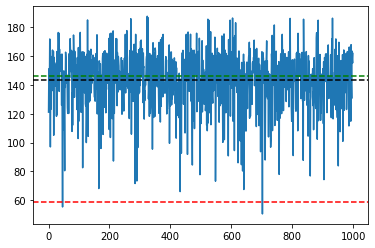

In [33]:
p = agent.env.params
aav = AAV(p)

plt.plot(rew_ag)
plt.axhline(np.mean(rew_ag), color='black', linestyle='--')
plt.axhline(-oav.v(0.11, 200), color='green', linestyle='--')
plt.axhline(np.mean(rew_aav), color='red', linestyle='--')

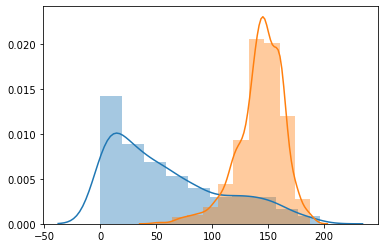

In [34]:
sns.distplot(rew_aav, bins=10)
sns.distplot(rew_ag, bins=10)

In [35]:
print(f"Optimal: {-oav.v(0.11, 200).flatten()[0]}")
print(f"Autonomous: {np.mean(rew_aav)}")
print(f"Learned: {np.mean(rew_ag)}, i.e. {(np.mean(rew_ag)-np.mean(rew_aav))/np.mean(rew_aav) * 100} % over autonomous and {(np.mean(rew_ag)+oav.v(0.11, 200).flatten()[0])/-oav.v(0.11, 200).flatten()[0] * 100} under optimal")

Optimal: 145.93779991894223
Autonomous: 59.08950695913813
Learned: 143.21189822397508, i.e. 142.36434790868992 % over autonomous and -1.8678517124975078 under optimal


## $\kappa=1.4$, $c=10$
Reference parameters from MS paper with 2x kappa -- 3 fully trained policies

In [94]:
ws = []
ls = []
for i, log in enumerate(logs[3:], 3):
    model_path, buffer = construct_paths(i)
    agent = DQNAgent.load(model_path)
    agent.main_net.compile(loss='MSE')
    ww, ll, aa, z = create_map(agent)
    w_front, l_front = get_frontier(ww, ll, aa)
    ws.append(w_front)
    ls.append(l_front)

[WARNING] [2020-08-06 14:28:57,114] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-08-06 14:28:57,211] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-08-06 14:29:05,789] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-08-06 14:29:05,883] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-08-06 14:29:13,274] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-08-06 14:29:13,370] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-08-06 14:29:20,887] [tensorflow] - No training configuration found in save file: the model was *

[INFO] [2020-08-06 14:30:21,482] [AAV] - Instantiated @ AAV
[INFO] [2020-08-06 14:30:21,497] [OAV] - Launching the value function procedure.
[INFO] [2020-08-06 14:30:21,498] [OAV] - Computing the value function on (0.00, 63.99].
[INFO] [2020-08-06 14:30:21,513] [OAV] - Computing the value function on (63.99, 71.10].
[INFO] [2020-08-06 14:30:23,158] [OAV] - Computing the value function on (71.10, 79.00].
[INFO] [2020-08-06 14:30:24,427] [OAV] - Computing the value function on (79.00, 87.78].
[INFO] [2020-08-06 14:30:25,373] [OAV] - Computing the value function on (87.78, 97.53].
[INFO] [2020-08-06 14:30:26,531] [OAV] - Computing the value function on (97.53, 108.37].
[INFO] [2020-08-06 14:30:27,706] [OAV] - Computing the value function on (108.37, 120.41].
[INFO] [2020-08-06 14:30:29,051] [OAV] - Computing the value function on (120.41, 133.79].
[INFO] [2020-08-06 14:30:30,517] [OAV] - Computing the value function on (133.79, 148.65].
[INFO] [2020-08-06 14:30:32,065] [OAV] - Computing t

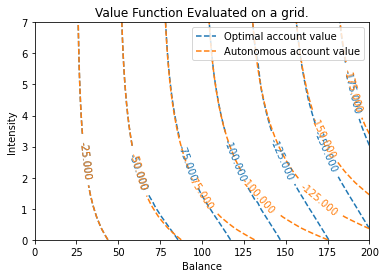

In [95]:
oav_h = OAV(agent.env.params, agent.env.w0, lmax=7)
oav_h.solve_v()
fig, ax = oav_h.plot_vf(plot_aav_flag=True)

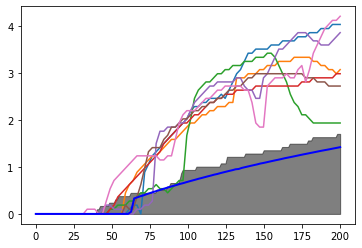

In [97]:
plt.plot(np.array(ws).T, np.array(ls).T)
plt.plot(oav_h.w_vector, oav_h.lambdastars, color='blue', linewidth=2)
plt.fill_between(w_front_opt, 0, l_front_opt, color = 'black', alpha = 0.5)

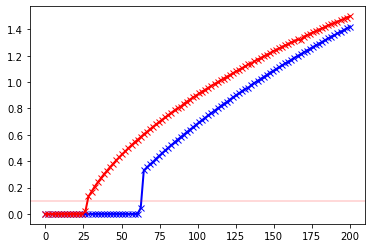

In [98]:
plt.plot(oav_h.w_vector, oav_h.lambdastars, color='blue', linewidth=2, marker='x')
plt.plot(oav.w_vector, oav.lambdastars, color='red', linewidth=2, marker='x')
plt.axhline(0.1, linewidth=0.3, color='red')

### check the value

In [148]:
rew_ag = evaluate_agent(agent, n=500)
rew_aav = evaluate_agent(agent, n=500, aav=True)

c:\users\majke\anaconda3\envs\tf2-gpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[INFO] [2020-07-30 12:39:41,419] [AAV] - Instantiated @ AAV


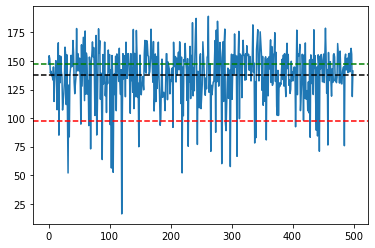

In [149]:
p = agent.env.params
aav = AAV(p)

plt.plot(rew_ag)
plt.axhline(np.mean(rew_ag), color='black', linestyle='--')
plt.axhline(-oav_h.v(0.11, 200), color='green', linestyle='--')
plt.axhline(np.mean(rew_aav), color='red', linestyle='--')

In [150]:
-oav_h.v(0.11, 200)

array([[147.51058615]])

sns.distplot(rew_aav, bins=10)
sns.distplot(rew_ag, bins=10)

In [153]:
print(f"Optimal: {-oav_h.v(0.11, 200).flatten()[0]}")
print(f"Autonomous: {np.mean(rew_aav)}")
print(f"Learned: {np.mean(rew_ag)}, i.e. {(np.mean(rew_ag)-np.mean(rew_aav))/np.mean(rew_aav) * 100} % over autonomous and {(np.mean(rew_ag)+oav_h.v(0.11, 200).flatten()[0])/-oav_h.v(0.11, 200).flatten()[0] * 100} under optimal")

Optimal: 147.5105861452479
Autonomous: 97.68104706051234
Learned: 137.73817679442948, i.e. 41.00808799592636 % over autonomous and -6.624886800460494 under optimal


In [100]:
import os

os.system('jupyter nbconvert --to html explore_learned_policies.ipynb')

0

# ******************* Comments ********************

In [ ]:
import seaborn as sns 
visits = [environment.convert_back(trans.s) for trans in buffer]
visits_w = np.array([vis[1] for vis in visits])
visits_l = np.array([vis[0] for vis in visits])

In [ ]:
sns.distplot(visits_w, bins=10)

In [ ]:
sns.distplot(visits_l, bins=10)

In [ ]:

import numpy as np
import numpy.random
import matplotlib.pyplot as plt

# Generate some test data
mask = visits_w > 0

x = visits_w[mask]
y = visits_l[mask]

# fig,ax = plt.subplots(figsize=(10,10))

heatmap, xedges, yedges = np.histogram2d(x, y, bins=(30,20))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', interpolation='nearest', aspect='auto')
# fig.show()

In [ ]:
np.max(y)

#### lets value this policy:

In [ ]:
agent.main_net.predict_on_batch(environment.observation(np.array([0.11, 200.]))[None, :])

In [ ]:
agent

In [ ]:

rewards = agent.evaluate(2)

In [ ]:
np.mean(rewards)

In [ ]:
from dcc import AAV, Parameters
p = Parameters()
p.c = 10.0
aav = AAV(p)

plt.plot(rewards)
plt.axhline(np.mean(rewards), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, MAX_ACCOUNT_BALANCE), color='red', linestyle='--', alpha=0.5)
plt.axhline(-aav.u(4.5, MAX_ACCOUNT_BALANCE) - 4.5*p.c, color='green', linestyle='--')

In [ ]:
p.c

In [ ]:
np.mean(rewards)

In [ ]:
u = -aav.u(0.11, MAX_ACCOUNT_BALANCE)

In [ ]:
import seaborn as sns
fig, ax = plt.subplots()
sns.distplot(rewards, ax=ax, bins=10)
sns.distplot(rew_aav, ax=ax, bins=10)
ax.axvline(np.mean(rewards), color='black', linestyle='--')
ax.axvline(np.mean(rew_aav), color='red', linestyle='--')
#ax.axvline(u, color='green', linestyle='--')

In [ ]:
# agent.evaluate(100)

In [ ]:
def sim():
    rewards = []
    w_states = []
    l_states = []
    actions = []
    for i in range(500):
        episode_reward = 0
        done = False
        state = environment.reset()
        while not done:
            # action = np.argmax(agent.main_net.predict_on_batch(state[None,:]))
            action, q = agent.get_action(state, epsilon=0.0)
            # action = 0
            actions.append(action)
            state, reward, done, _ = environment.step(action)
            episode_reward += reward
            converted_state = environment.convert_back(state)
            w_states.append(converted_state[1])
            l_states.append(converted_state[0])
            if episode_reward>200:
                break
            if done:
                rewards.append(episode_reward)
    return rewards

rew_aav = sim()
        

In [ ]:
#plt.plot(results['REINFORCE AB'])
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)

plt.plot(rew_aav)
plt.axhline(np.mean(rew_aav), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, 100), color='red', linestyle='--')

In [ ]:
import seaborn as sns
fig, ax = plt.subplots()
# sns.distplot(rewards, ax=ax, bins=10)
sns.distplot(rew_aav, ax=ax, bins=10)
# ax.axvline(np.mean(rewards), color='black', linestyle='--')
ax.axvline(np.mean(rew_aav), color='red', linestyle='--')

Statespace path

In [ ]:
rewards = []
w_states = []
l_states = []
actions = []
for i in range(1):
    episode_reward = 0
    done = False
    state = environment.reset()
    while not done:
        # action = np.argmax(agent.main_net.predict_on_batch(state[None,:]))
        action, q = agent.get_action(state, epsilon=0.0)
        #action = 0
        actions.append(action)
        state, reward, done, _ = environment.step(action)
        episode_reward += reward
        converted_state = environment.convert_back(state)
        w_states.append(converted_state[1])
        l_states.append(converted_state[0])
        if episode_reward>200:
            break
        if done:
            rewards.append(episode_reward)


In [ ]:
l_states[0]

In [ ]:
fig, ax = plt.subplots()
ax.plot(w_states, l_states, marker='x')
ax.set_xlabel('Balance')
ax.set_ylabel('Intensity')

In [ ]:
 environment.reset()

In [ ]:
fig, ax = plt.subplots()
ax.plot(actions, marker='x')
ax.set_xlabel('steps')
ax.set_ylabel('Action size applied')

In [ ]:
plt.plot(rewards)

Test policy that separates linearly the statespace by y=x

In [ ]:
def dummy_policy(state):
    if state[1] > state[0]:
        return 0
    else:
        return 1

In [ ]:
rewards = []
w_states = []
l_states = []
actions = []
for i in range(1000):
    episode_reward = 0
    done = False
    state = environment.reset()
    while not done:
        action = dummy_policy(state)
        actions.append(action)
        state, reward, done, _ = environment.step(action)
        episode_reward += reward
        converted_state = environment.convert_back(state)
        w_states.append(converted_state[1])
        l_states.append(converted_state[0])
        if done:
            rewards.append(episode_reward)

In [ ]:
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)

plt.plot(rewards)
plt.axhline(np.mean(rewards), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, 100), color='red', linestyle='--')